## Three Algorithms for Computing Dynamic Models

Here we will solve the basic infinite horizon growth model. The representative consumer has CRRA utility, $u(c_t) = c_t^{1-\gamma}/(1-\gamma)$ and she discounts the future at a rate $\beta$. Her production function is solely a function of capital $F(k_t) = k_t^\alpha$, and capital fully depreciates so that $k_{t+1} = F(k_t) - c_t.$

Solve this model with three methods:
1. Value function iteration
2. Fixed point iteration
3. Time iteration

For fixed point iteration, solve for the Euler equation and then put it in fixed point form. Then approximate the optimal policy function, $c_t = C(k_t)$ by iterating on the transformed Euler equation.

For time iteration, solve a root-finding problem on the Euler equation.

Parameter values for the model are:
- $\alpha = 0.75$
- $\beta = 0.95$
- $\gamma = 2$

Use between $5-10$ collocation nodes and a damping parameter of $0.7$ (only 70% weight on the new coefficient update) for a stable solution.

Here we will compute errors for the different solution methods using Euler equation residuals and other techniques.

### Value Function Iteration

In [46]:
# Packages for collocation and for plotting
using CompEcon
using PyPlot
using Roots
using Optim

# Model parameters
gamma = 2. # RIA
alpha = 0.75 # Capital share
beta = 0.95 # Discount factor
damp = 1. # Damping
tol = 1e-4 # Tolerance
error = 1e10 # Initial error

# Steady state capital
steady_capital = (alpha*beta)^(1/(1-alpha))

# Upper bound of approximation domain
upper_bound = 1.5.*steady_capital

# Lower bound of approximation domain
lower_bound = 0.5*steady_capital

# Number of collocation nodes
num_nodes = 5

# Function space
space = fundefn(:cheb,num_nodes,lower_bound,upper_bound)

# Collocation grid
s, bounds = funnode(space)

# Number of collocation nodes
space[:num_nodes] = num_nodes

# Initial coefficient vector
space[:c] = .1*ones(space[:num_nodes])

# Preinvert polynomial matrix for computing coefficients
Binv = funbase(space,s)\eye(space[:num_nodes],space[:num_nodes])

5×5 Array{Float64,2}:
  0.2        0.2        0.2   0.2       0.2     
 -0.380423  -0.235114   0.0   0.235114  0.380423
  0.323607  -0.123607  -0.4  -0.123607  0.323607
 -0.235114   0.380423  -0.0  -0.380423  0.235114
  0.123607  -0.323607   0.4  -0.323607  0.123607

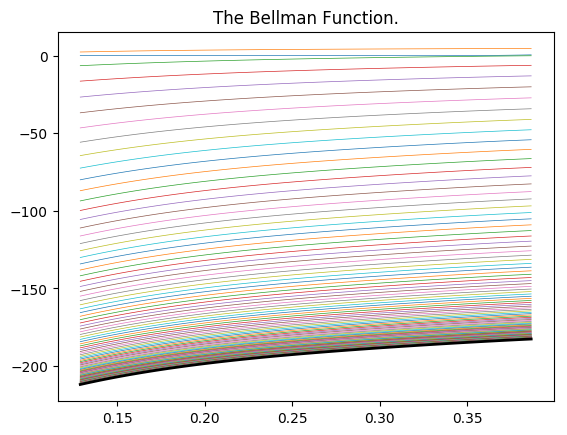

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9da334e790>

In [47]:
## VALUE FUNCTION ITERATION

# Initialize value array
value = -.0*ones(space[:num_nodes])

# Initial error
error = 1e10 

while error > tol
    
    # Initialize consumption array
    c = zeros(100)

    # Put a fine grid over the capital domain
    capital_levels = linspace(lower_bound,upper_bound,100)

    # Compute optimal consumption at all capital grid points
    for t = 1:100
        c_out, c_eval = funeval(space[:c],space,[capital_levels[t]])
        c[t] = c_out[1]
    end

    # Plot policy function
    plot(capital_levels, c, linewidth=0.5)
    
    title("The Bellman Function.")
    
    # Compute next period's consumption from the Euler equation
    for i = 1:space[:num_nodes]
        
        # Initialize difference
        d = 1e10
        
        capital = s[i]

        # Bellman equation
        # V(k_t) = max_{c_t} u(c_t) + beta V(k_{t+1})
        function bellman(consi::Float64)
        
            # Next period's capital given current capital and consumption
            capital_next = capital^alpha-consi
        
            # Continuation given current capital and consumption
            cont_value, eval = funeval(space[:c],space,[capital_next])
        
            # Total payoff
            if gamma == 1.
                value = log(consi) + beta*cont_value
            else
                value = (consi)^(1-gamma)/(1-gamma) + beta*cont_value
            end
            return -value[1]
            
        end
        
        results = optimize(bellman, 0.25*capital^alpha, 0.99*capital^alpha)
        
        # Compute new value
        value[i] = -Optim.minimum(results)
    end
    
    # New coefficients on approximant, damp the update
    c_next = damp*(Binv*value) + (1-damp)*space[:c]

    # Relative change in coefficients at collocation nodes
    error = maximum(abs.((Binv*value-space[:c])./(Binv*value)))

    # Update coefficients
    space[:c] = c_next

    # Display error
    #println("Maximum Error of $(error).")
    

end

# Initialize consumption array
c = zeros(100)

# Put a fine grid over the capital domain
capital_levels = linspace(lower_bound,upper_bound,100)

# Compute optimal consumption at all capital grid points
for t = 1:100
    c_out, c_eval = funeval(space[:c],space,[capital_levels[t]])
    c[t] = c_out[1]
end

# Plot policy function
plot(capital_levels, c, linewidth=2.0, color="black")

In [48]:
# Simulate using solved Bellman function

# Horizon of simulation
horizon = 100

# Initialize capital and consumption vectors
k = zeros(horizon+1)
c = zeros(horizon)

# Initial capital value
k[1] = steady_capital/2

# Simulate
for t = 1:horizon

    capital = k[t]
    
    # Bellman equation
    # V(k_t) = max_{c_t} u(c_t) + beta V(k_{t+1})
    function bellman(consi::Float64)
    
        # Next period's capital given current capital and consumption
        capital_next = capital^alpha-consi
    
        # Continuation given current capital and consumption
        cont_value, eval = funeval(space[:c],space,[capital_next])
    
        # Total payoff
        if gamma == 1.
            value = log(consi) + beta*cont_value
        else
            value = (consi)^(1-gamma)/(1-gamma) + beta*cont_value
        end
        
        return -value[1]
        
    end
    
    results = optimize(bellman, 0., capital^alpha)
    
    # Compute new value
    c[t] = Optim.minimizer(results)
    k[t+1] = capital^alpha-c[t]
end



### Compute the Euler equation residuals along the simulated trajectory.

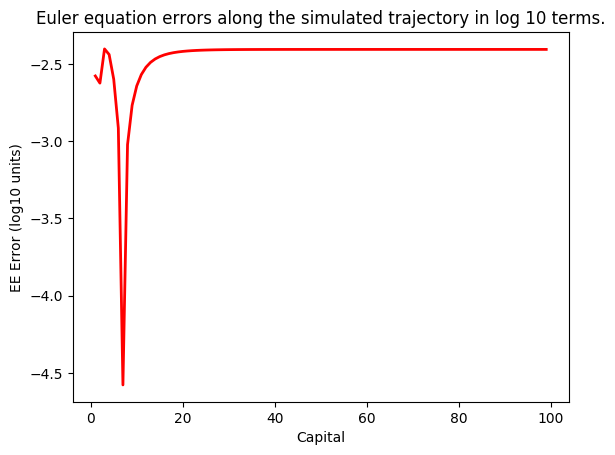

Along the simulated trajectory we have a mean Euler error of -2.4570156136061394 and a maximum Euler error of -2.4018695734890163.


In [49]:
# Euler equation:
# u'(c_t) = beta*u'(c_t+1)*F'(k_t+1)
# Redefine as 0 = u'^(-1)(beta*u'(c_t+1)*F'(k_t+1))/c_t - 1
# This gives it an expression that is consumption units (per consumption)

# Initialize error vector
euler_error = zeros(horizon-1)

# Compute Euler equation error at each time period
# Put into log10 terms of the absolute value of the error. More negative numbers are better.
# -4 means error is 10^-4, -3 means the error is 10^-3, etc.
for t = 1:horizon-1
    euler_error[t] = log10(abs((beta*c[t+1]^(-gamma)*alpha*k[t+1]^(alpha-1))^(-1/gamma)/(c[t]) - 1))
end

# Compute mean and maximum errors
mean_error = mean(euler_error)
max_error = maximum(euler_error)

# Plot
plot(1:horizon-1, euler_error, color="red", linewidth=2.0)
title("Euler equation errors along the simulated trajectory in log 10 terms.")
ylabel("EE Error (log10 units)")
xlabel("Capital")
println("Along the simulated trajectory we have a mean Euler error of $(mean_error) and a maximum Euler error of $(max_error).")

### Compute the Euler equation error along the entire capital domain

This is easy to do since it is only a one dimensional problem. Usually it can be difficult to compute EE errors across the whole state space.

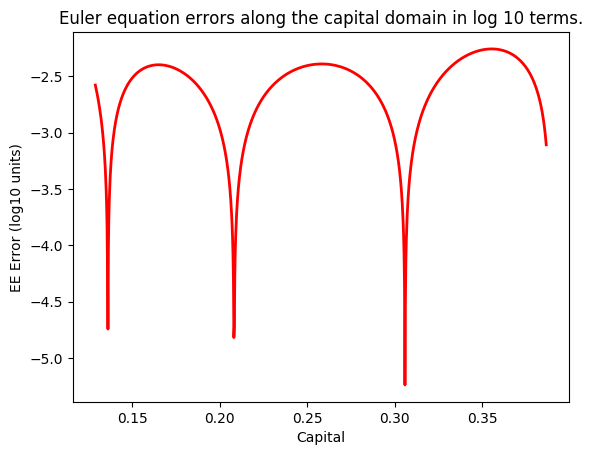

The mean Euler equation error is -2.644690497351318 and the maximum error is -2.255966675200757.


In [50]:
# Simulate using solved Bellman function

# Euler equation:
# u'(c_t) = beta*u'(c_t+1)*F'(k_t+1)
# Redefine as 0 = beta*u'(c_t+1)*F'(k_t+1)/u'(c_t) - 1
# This gives it an expression that is UNITLESS

# Number of grid points
num_points = 1000

# Initialize error vector
euler_error = zeros(num_points)

# Put a fine grid over the capital domain
capital_levels = linspace(lower_bound,upper_bound,num_points)

# Initialize capital and consumption vectors
k = zeros(num_points)
c = zeros(num_points)

t = 1

# Compute Euler equation error at each time period
# Put into log10 terms. More negative numbers are better.
# -4 means error is 10^-4, -3 means the error is 10^-3, etc.
# Given the current capital state get the current consumption level
# and the future consumption and capital levels
for k in capital_levels
    
    capital = k
    
    # Bellman equation
    # V(k_t) = max_{c_t} u(c_t) + beta V(k_{t+1})
    function bellman(consi::Float64)
    
        # Next period's capital given current capital and consumption
        capital_next = capital^alpha-consi
    
        # Continuation given current capital and consumption
        cont_value, eval = funeval(space[:c],space,[capital_next])
    
        # Total payoff
        if gamma == 1.
            value = log(consi) + beta*cont_value
        else
            value = (consi)^(1-gamma)/(1-gamma) + beta*cont_value
        end
        
        return -value[1]
        
    end
    
    results = optimize(bellman, 0., capital^alpha)
    
    # Compute new value
    ct = Optim.minimizer(results)
    kt1 = capital^alpha-ct
    
    capital = kt1
    
    # Bellman equation
    # V(k_t) = max_{c_t} u(c_t) + beta V(k_{t+1})
    function bellman(consi::Float64)
    
        # Next period's capital given current capital and consumption
        capital_next = capital^alpha-consi
    
        # Continuation given current capital and consumption
        cont_value, eval = funeval(space[:c],space,[capital_next])
    
        # Total payoff
        if gamma == 1.
            value = log(consi) + beta*cont_value
        else
            value = (consi)^(1-gamma)/(1-gamma) + beta*cont_value
        end
        
        return -value[1]
        
    end
    
    results = optimize(bellman, 0., capital^alpha)
    
    # Compute new value
    ct1 = Optim.minimizer(results)
    
    euler_error[t] = log10(abs((beta*ct1[1]^(-gamma)*alpha*kt1^(alpha-1))^(-1/gamma)/(ct[1]) - 1))
    t+= 1
end


# Compute mean and maximum errors
mean_error = mean(euler_error)
max_error = maximum(euler_error)

# Plot
plot(capital_levels, euler_error, color="red", linewidth=2.0)
title("Euler equation errors along the capital domain in log 10 terms.")
ylabel("EE Error (log10 units)")
xlabel("Capital")

println("The mean Euler equation error is $(mean_error) and the maximum error is $(max_error).")


### Fixed Point Iteration

In [51]:
# Model parameters, only changes to FPI from VFI
damp = 1. # Damping
tol = 1e-4 # Tolerance
error = 1e10 # Initial error

1.0e10

In [52]:
# Fixed point Euler equation

# c_t = u'^(-1)(beta*u'(c_t+1)*F'(k_t+1))
# k_t+1 = F(k_t) - c_t
function consumption_euler(capital::Float64,space::Dict{Symbol,Any})

    # Current consumption given current capital
    cons, eval = funeval(space[:c],space,[capital])

    # Next period's capital given current capital and consumption
    capital_next = capital^alpha-cons

    # Next period's consumption given current capital and consumption
    cons_next, eval = funeval(space[:c],space,capital_next)
    cons_next = max(1e-10,cons_next)
    
    # Next period's consumption from Euler equation
    cons_next = (beta*cons_next^(-gamma)*alpha*(capital_next).^(alpha-1)).^(-1/gamma)
    return cons_next[1]
end

consumption_euler (generic function with 1 method)

Maximum Error of 1.0.
Maximum Error of 0.5812153738522248.
Maximum Error of 5.410358029133678.
Maximum Error of 0.9109869858248911.
Maximum Error of 3.551343385520023.
Maximum Error of 1.4110754737750175.
Maximum Error of 1.2128112319610267.
Maximum Error of 31.78897159693115.
Maximum Error of 0.9621634775202837.
Maximum Error of 8.04232613519243.
Maximum Error of 1.8341677203612725.
Maximum Error of 0.7108722593622858.
Maximum Error of 6.221037564559722.
Maximum Error of 3.3038179559273404.
Maximum Error of 1.130621307417404.
Maximum Error of 0.6255238651045862.
Maximum Error of 2.0063117430870707.
Maximum Error of 1.3563289466495358.
Maximum Error of 0.5859980361367161.
Maximum Error of 0.517701015112846.
Maximum Error of 3.9195182580534755.
Maximum Error of 0.8805636671489715.
Maximum Error of 7.543867282217797.
Maximum Error of 1.5532844423096224.
Maximum Error of 1.6426649143588063.
Maximum Error of 2.2889569532444773.
Maximum Error of 2.3731542402512367.
Maximum Error of 2.333912

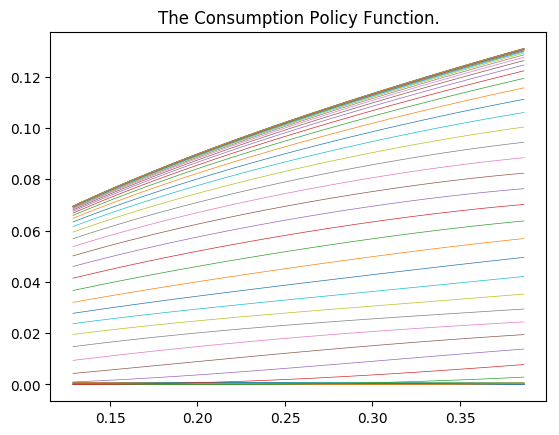

Maximum Error of 0.0015406525795623467.
Maximum Error of 0.0011076347509876253.
Maximum Error of 0.000796141530065856.
Maximum Error of 0.0005721638326936201.
Maximum Error of 0.00041115918574929726.
Maximum Error of 0.00029544342190292134.
Maximum Error of 0.00021228699005007857.
Maximum Error of 0.0001525329324431824.
Maximum Error of 0.00010959712092141793.
Maximum Error of 7.874672446478715e-5.


In [53]:
## FIXED POINT ITERATION

# Initial coefficient vector
space[:c] = .0*ones(space[:num_nodes])

# Initialize consumption array
cons_next = Array{Float64}(space[:num_nodes])

while error > tol
    
    # Plot optimal policy function

    # Initialize consumption array
    c = zeros(100)

    # Put a fine grid over the capital domain
    capital_levels = linspace(lower_bound,upper_bound,100)

    # Compute optimal consumption at all capital grid points
    for t = 1:100
        c_out, c_eval = funeval(space[:c],space,[capital_levels[t]])
        c[t] = c_out[1]
    end

    # Plot policy function
    plot(capital_levels, c, linewidth=0.5)
    title("The Consumption Policy Function.")
    
    # Compute next period's consumption from the Euler equation
    for i = 1:space[:num_nodes]
        cons_next[i] = consumption_euler(s[i],space)
    end

    # New coefficients on approximant, damp the update
    c_next = damp*(Binv*cons_next) + (1-damp)*space[:c]

    # Relative change in coefficients at collocation nodes
    error = maximum(abs.((c_next-space[:c])./c_next))

    # Update coefficients
    space[:c] = c_next

    # Display error
    println("Maximum Error of $(error).")
end

# Plot optimal policy function

# Initialize consumption array
c = zeros(100)

# Put a fine grid over the capital domain
capital_levels = linspace(lower_bound,upper_bound,100)

# Compute optimal consumption at all capital grid points
for t = 1:100
    c_out, c_eval = funeval(space[:c],space,[capital_levels[t]])
    c[t] = c_out[1]
end

In [54]:
# Simulate using solved policy function

# Horizon of simulation
horizon = 100

# Initialize capital and consumption vectors
k = zeros(horizon+1)
c = zeros(horizon)

# Initial capital value
k[1] = steady_capital/2

# Simulate
for t = 1:horizon
    c_out, c_eval = funeval(space[:c],space,[k[t]])
    c[t] = c_out[1]
    k[t+1] = k[t]^alpha-c[t]
end

### Compute the Euler equation residuals along the simulated trajectory.

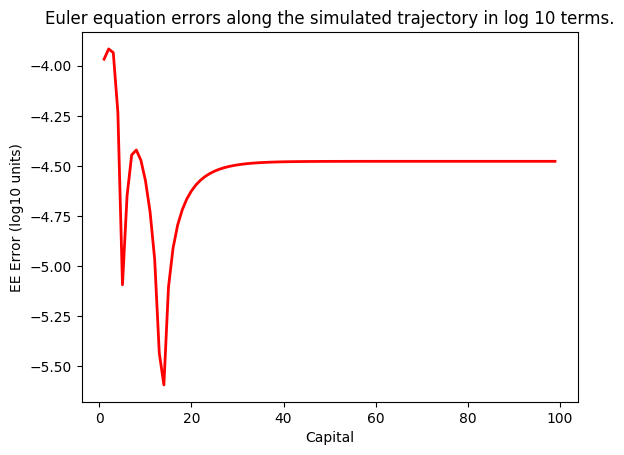

Along the simulated trajectory we have a mean Euler error of -4.520776052704386 and a maximum Euler error of -3.916086976484041.


In [55]:
# Euler equation:
# u'(c_t) = beta*u'(c_t+1)*F'(k_t+1)
# Redefine as 0 = u'^(-1)(beta*u'(c_t+1)*F'(k_t+1))/c_t - 1
# This gives it an expression that is consumption units (per consumption)

# Initialize error vector
euler_error = zeros(horizon-1)

# Compute Euler equation error at each time period
# Put into log10 terms of the absolute value of the error. More negative numbers are better.
# -4 means error is 10^-4, -3 means the error is 10^-3, etc.
for t = 1:horizon-1
    euler_error[t] = log10(abs((beta*c[t+1]^(-gamma)*alpha*k[t+1]^(alpha-1))^(-1/gamma)/(c[t]) - 1))
end

# Compute mean and maximum errors
mean_error = mean(euler_error)
max_error = maximum(euler_error)

# Plot
plot(1:horizon-1, euler_error, color="red", linewidth=2.0)
title("Euler equation errors along the simulated trajectory in log 10 terms.")
ylabel("EE Error (log10 units)")
xlabel("Capital")
println("Along the simulated trajectory we have a mean Euler error of $(mean_error) and a maximum Euler error of $(max_error).")

### Compute the Euler equation error along the entire capital domain

This is easy to do since it is only a one dimensional problem. Usually it can be difficult to compute EE errors across the whole state space.

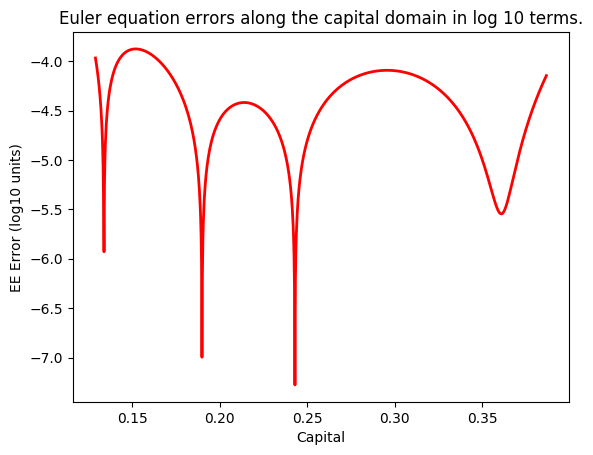

The mean Euler equation error is -4.491736117815968 and the maximum error is -3.8755182903564465.


In [56]:
# Euler equation:
# u'(c_t) = beta*u'(c_t+1)*F'(k_t+1)
# Redefine as 0 = beta*u'(c_t+1)*F'(k_t+1)/u'(c_t) - 1
# This gives it an expression that is UNITLESS

# Number of grid points
num_points = 1000

# Initialize error vector
euler_error = zeros(num_points)

# Put a fine grid over the capital domain
capital_levels = linspace(lower_bound,upper_bound,num_points)

# Initialize capital and consumption vectors
k = zeros(num_points)
c = zeros(num_points)

# Compute Euler equation error at each time period
# Put into log10 terms. More negative numbers are better.
# -4 means error is 10^-4, -3 means the error is 10^-3, etc.
# Given the current capital state get the current consumption level
# and the future consumption and capital levels
t = 1
for k in capital_levels
    ct, ct_eval = funeval(space[:c],space,[k])
    kt1 = k^alpha-ct[1]
    ct1, ct1_eval = funeval(space[:c],space,[kt1])
    euler_error[t] = log10(abs((beta*ct1[1]^(-gamma)*alpha*kt1^(alpha-1))^(-1/gamma)/(ct[1]) - 1))
    t+= 1
end

# Compute mean and maximum errors
mean_error = mean(euler_error)
max_error = maximum(euler_error)

# Plot
plot(capital_levels, euler_error, color="red", linewidth=2.0)
title("Euler equation errors along the capital domain in log 10 terms.")
ylabel("EE Error (log10 units)")
xlabel("Capital")

println("The mean Euler equation error is $(mean_error) and the maximum error is $(max_error).")

### Compute the den Haan and Marcet $\chi^2$ test statistic

In [57]:
# Euler equation:
# u'(c_t) = beta*u'(c_t+1)*F'(k_t+1)
# Redefine as 0 = u'^(-1)(beta*u'(c_t+1)*F'(k_t+1))/c_t - 1
# This gives it an expression that is consumption units (per consumption)

# Simulate using solved policy function

# Horizon of simulation
horizon = 100

# Initialize capital and consumption vectors
k = zeros(horizon+1)
c = zeros(horizon)

# Initial capital value
k[1] = steady_capital/2

# Simulate
for t = 1:horizon
    c_out, c_eval = funeval(space[:c],space,[k[t]])
    c[t] = c_out[1]
    k[t+1] = k[t]^alpha-c[t]
end


# Initialize error vector
num_runs = 1
euler_error = zeros(num_runs,horizon-1)
x_vector = Array{Array{Float64}}(num_runs)

# Do num_run simulations
for run = 1:num_runs
    
    # Simulate each run
    for t = 1:horizon-1
    
        # Euler equation that should be equal to zero
        euler_error[run,t] = (beta*c[t+1]^(-gamma)*alpha*k[t+1]^(alpha-1))^(-1/gamma)/(c[t]) - 1
        # Store capital observations
        if t == 1
            k_prev = copy(k[t])
        else
            k_prev = copy(k[t])
            # Append to x vector
            if t == 2
                x_vector[run] = [1 k_prev]
            else
                x_vector[run] = vcat(x_vector[run],[1 k_prev])
            end
            
        end
        
    end
end


test_stat = Array{Float64}(num_runs)

function kron_sum(euler_error::Array,x_vector::Array)
    
    sum_of_kron = 0
    # Simulate each run
    for t = 1:horizon-1
        
        
        

    end
    
    [kron(euler_error[t],x_vector[t-1,:]) for t = 2:horizon-1]

end
    

# Do num_run simulations
for run = 1:num_runs
    test_stat[run] = kron_sum(euler_error[run,:],x_vector[run])
end

LoadError: MethodError: Cannot `convert` an object of type Array{Array{Float64,1},1} to an object of type Float64
This may have arisen from a call to the constructor Float64(...),
since type constructors fall back to convert methods.

### Time Iteration

In [58]:
# Model parameters, only changes to TI from VFI
damp = 0.7 # Damping
tol = 1e-4 # Tolerance
error = 1e10 # Initial error

1.0e10

In [59]:
## TIME ITERATION

# Initial coefficient vector
space[:c] = 0.*ones(space[:num_nodes])

# Initialize consumption array
cons = Array{Float64}(space[:num_nodes])

while error > tol
    
    # Compute next period's consumption from the Euler equation
    for i = 1:space[:num_nodes]

      capital = s[i]
      
      # Time iteration Euler equation
      # u'(c_t(k_t)) = beta*u'(c_t+1(c_t(k_t),k_t))*F'(k_t+1(c(k_t),k_t))
      # k_t+1 = F(k_t) - c_t
      function euler(cons_guess::Float64)
      
          # Next period's capital given current capital and consumption
          capital_next = capital^alpha-cons_guess
          
          # Next period's consumption given current capital and consumption
          cons_next, eval = funeval(space[:c],space,[capital_next])
          cons_next = max(1e-10,cons_next)
          # Next period's consumption from Euler equation
          euler_error = cons_guess^(-gamma)./(beta*cons_next^(-gamma)*alpha*(capital_next).^(alpha-1))-1
          return euler_error[1]
      end
        
        # Try bracketing search, otherwise do initial guess search
        try 
            cons[i] = fzero(euler,0.,capital)
        catch
            cons[i] = fzero(euler,capital/2)
        end
        
    end

    # New coefficients on approximant, damp the update
    c_next = damp*(Binv*cons) + (1-damp)*space[:c]

    # Relative change in coefficients at collocation nodes
    error = maximum(abs.((c_next-space[:c])./c_next))

    # Update coefficients
    space[:c] = c_next

    # Display error
    println("Maximum Error of $(error).")
end

Maximum Error of 1.0.
Maximum Error of 0.23076923076923084.
Maximum Error of 2.193983856101355.
Maximum Error of 2.3989857795581258.
Maximum Error of 1.8959749504333128.
Maximum Error of 0.5306000146482039.
Maximum Error of 11.796629073707853.
Maximum Error of 1.0706610194230899.
Maximum Error of 0.6646443878765145.
Maximum Error of 0.4897803725421947.
Maximum Error of 1.5854433015979768.
Maximum Error of 1.529403814181504.
Maximum Error of 1.0487484011281463.
Maximum Error of 1.6744586281230498.
Maximum Error of 1.0279526066127236.
Maximum Error of 18.09927586935422.
Maximum Error of 0.9159015739760699.
Maximum Error of 2.0101027080594167.
Maximum Error of 2.8959890977160634.
Maximum Error of 0.8131017743749842.
Maximum Error of 0.4059250617505178.
Maximum Error of 3.721459394833369.
Maximum Error of 1.4816926029073263.
Maximum Error of 4.2782256570986865.
Maximum Error of 0.8345698995008844.
Maximum Error of 0.5707343572923005.
Maximum Error of 0.5071339132561326.
Maximum Error of 18

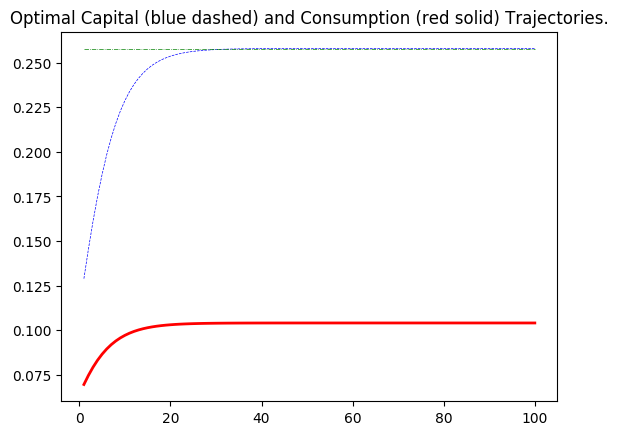

Validate the solution: Does the final capital value of 0.2579187524343337 arrive at the analytically derived capital steady state of 0.2577148681640624?


In [60]:
# Simulate using solved policy function

# Horizon of simulation
horizon = 100

# Initialize capital and consumption vectors
k = zeros(horizon+1)
c = zeros(horizon)

# Initial capital value
k[1] = steady_capital/2

# Simulate
for t = 1:horizon
    c_out, c_eval = funeval(space[:c],space,[k[t]])
    c[t] = c_out[1]
    k[t+1] = k[t]^alpha-c[t]
end

# Plot
plot(1:horizon, c, color="red", linewidth=2.0)
plot(1:horizon, k[1:end-1], color="blue", linewidth=0.5, linestyle="--")
plot(1:horizon, steady_capital*ones(horizon), color="green", linewidth=0.5, linestyle="-.")
title("Optimal Capital (blue dashed) and Consumption (red solid) Trajectories.")
println("Validate the solution: Does the final capital value of $(k[end]) arrive at the analytically derived capital steady state of $(steady_capital)?")